# Project: Modelling the Spread of Cvoid-19

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib; matplotlib.use('TkAgg')
from scipy.integrate import odeint
from matplotlib import cm
import math
import pandas as pd
from scipy.fftpack import fft,fftfreq
import scipy.stats as stats

%matplotlib inline
import json
import random
import warnings
import dynetx as dn
import networkx as nx
from bokeh.io import show
import ndlib.models.dynamic as dm
from ndlib.utils import multi_runs
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
import ndlib.models.CompositeModel as gc
import ndlib.models.compartments.NodeStochastic as ns
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence

# Problem 1: Gillespie’s Direct Algorithm
Begin with SIR without demography, then add demography, and finally add imports to the model.
## 1.1 SIR without demograpy
# Build a basic SIR model as class

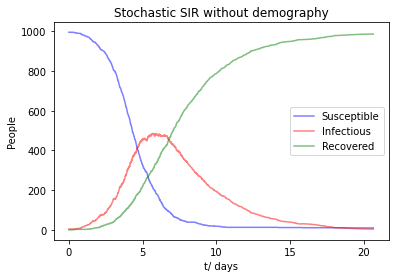

In [59]:

class SIR_basic(object):

    # Set the initial parameters
    def __init__(self, S0, I0, R0, beta, gamma, t_stop):
        self.S, self.I, self.R, self.t = [], [], [], []
        self.S.append(S0), self.I.append(I0), self.R.append(R0)
        self.t.append(0)

    
    # Simulate random events happening
    def events(self):
        while self.t[-1] < t_stop:
            N = self.S[-1]+self.I[-1] + self.R[-1]
            Rate1 = beta * self.S[-1] * self.I[-1]/N
            Rate2 = gamma * self.I[-1]
           
            Rate_total = Rate1 + Rate2 
            
            if Rate_total == 0:
                break
            ran1,ran2 = np.random.uniform(0,1), np.random.uniform(0,1) * Rate_total
            t_step = -math.log(ran1) / Rate_total
            self.t.append(self.t[-1]+t_step)

            if ran2 < Rate1:          # Event 1: infection, 0.01??
                self.S.append(self.S[-1]-1)
                self.I.append(self.I[-1]+1)
                self.R.append(self.R[-1])
            else:                     # Event 2: recovery
                self.S.append(self.S[-1])
                self.I.append(self.I[-1]-1)
                self.R.append(self.R[-1]+1)
            
        return [self.t, self.S, self.I, self.R]




# Set the initial values
S0 = 995
I0 = 5
R0 = 0
beta = 1.4
gamma = 0.3
t_stop = 20

# Operate class function

results = SIR_basic(S0, I0, R0, beta, gamma, t_stop).events()


# Plot basic SIR model
plt.plot(results[0], results[1], c="b", alpha=0.5, label="Susceptible")
plt.plot(results[0], results[2], c="r", alpha=0.5, label="Infectious")
plt.plot(results[0], results[3], c="g", alpha=0.5, label="Recovered")
plt.legend()
plt.xlabel("t/ days")
plt.ylabel("People")
plt.title("Stochastic SIR without demography")
plt.savefig('e_1.jpg',dpi=200)
plt.show()


## 1.2 SIR model with demography and imports

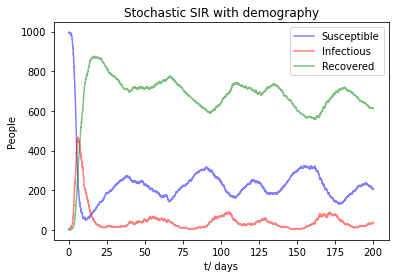

In [72]:
# Build a SIR model with demography and imports as class

class SIR_demography(object):

    # Set the initial parameters
    def __init__(self, S0, I0, R0, beta, gamma, mu, epsilon, t_stop):
        self.S,self.I,self.R,self.t = [],[],[],[]
        self.S.append(S0), self.I.append(I0), self.R.append(R0)
        self.t.append(0)
        self.beta = beta
        self.gamma = gamma
        self.mu = mu
        self.epsilon = epsilon
    
    # Simulate random events happening
    def events(self):
        while self.t[-1] < t_stop:
            N = self.S[-1] + self.I[-1] + self.R[-1]
            
            Rate1 = self.beta * self.S[-1] * self.I[-1] / N
            Rate2 = self.gamma * self.I[-1]
            Rate3 = self.mu * N
            Rate4 = self.mu * self.S[-1]
            Rate5 = self.mu * self.I[-1]
            Rate6 = self.mu * self.R[-1]
            Rate7 = self.epsilon 
            Rate_total = Rate1 + Rate2 + Rate3 + Rate4 + Rate5 + Rate6 + Rate7
            if Rate_total == 0:
                break
            ran1,ran2 = np.random.uniform(0,1), np.random.uniform(0,1) * Rate_total
            t_step = -math.log(ran1) / Rate_total
            self.t.append(self.t[-1] + t_step)

            if ran2 < Rate1:                     
                # Event 1: Infection
                SIR_demography.events_stay(self)
                self.S[-1] -= 1
                self.I[-1] += 1
            elif ran2 < (Rate1 + Rate2):   
                # Event 2: Recovery
                SIR_demography.events_stay(self)
                self.I[-1] -= 1
                self.R[-1] += 1
            elif ran2 < (Rate1 + Rate2 + Rate3):
                # Event 3: Birth   
                SIR_demography.events_stay(self)
                self.S[-1] += 1
            elif ran2 < (Rate1 + Rate2 + Rate3 + Rate4):  
                # Event 4: Death in S   
                SIR_demography.events_stay(self)
                self.S[-1] -= 1
            elif ran2 < (Rate1 +Rate2 + Rate3 + Rate4 + Rate5):  
                # Event 5: Death in I 
                SIR_demography.events_stay(self)
                self.I[-1] -= 1
            elif ran2 < (Rate1 + Rate2 + Rate3 + Rate4 + Rate5 + Rate6): 
                # Event 6: Death in R  
                SIR_demography.events_stay(self)
                self.R[-1] -= 1
            else:
                # Event 7: Imports
                SIR_demography.events_stay(self)
                self.I[-1] += 1
            
        return [self.t, self.S, self.I, self.R]

    def events_stay(self):    
        self.S.append(self.S[-1])
        self.I.append(self.I[-1])
        self.R.append(self.R[-1])

# Set the initial values
S0 = 995
I0 = 5
R0 = 0
beta = 1.4
gamma = 0.3
mu=1/60
epsilon = 0.001
t_stop = 200

# Operate class function

results = SIR_demography(S0, I0, R0, beta, gamma, mu, epsilon, t_stop).events()

# Plot SIR model
plt.plot(results[0], results[1], c="b", alpha=0.5, label="Susceptible")
plt.plot(results[0], results[2], c="r", alpha=0.5, label="Infectious")
plt.plot(results[0], results[3], c="g", alpha=0.5, label="Recovered")
plt.legend()
plt.xlabel("t/ days")
plt.ylabel("People")
plt.title("Stochastic SIR with demography")
plt.savefig('e_2.jpg',dpi=200)
plt.show()


## 1.3 Five hallmarks
### 1.3.1 Variability

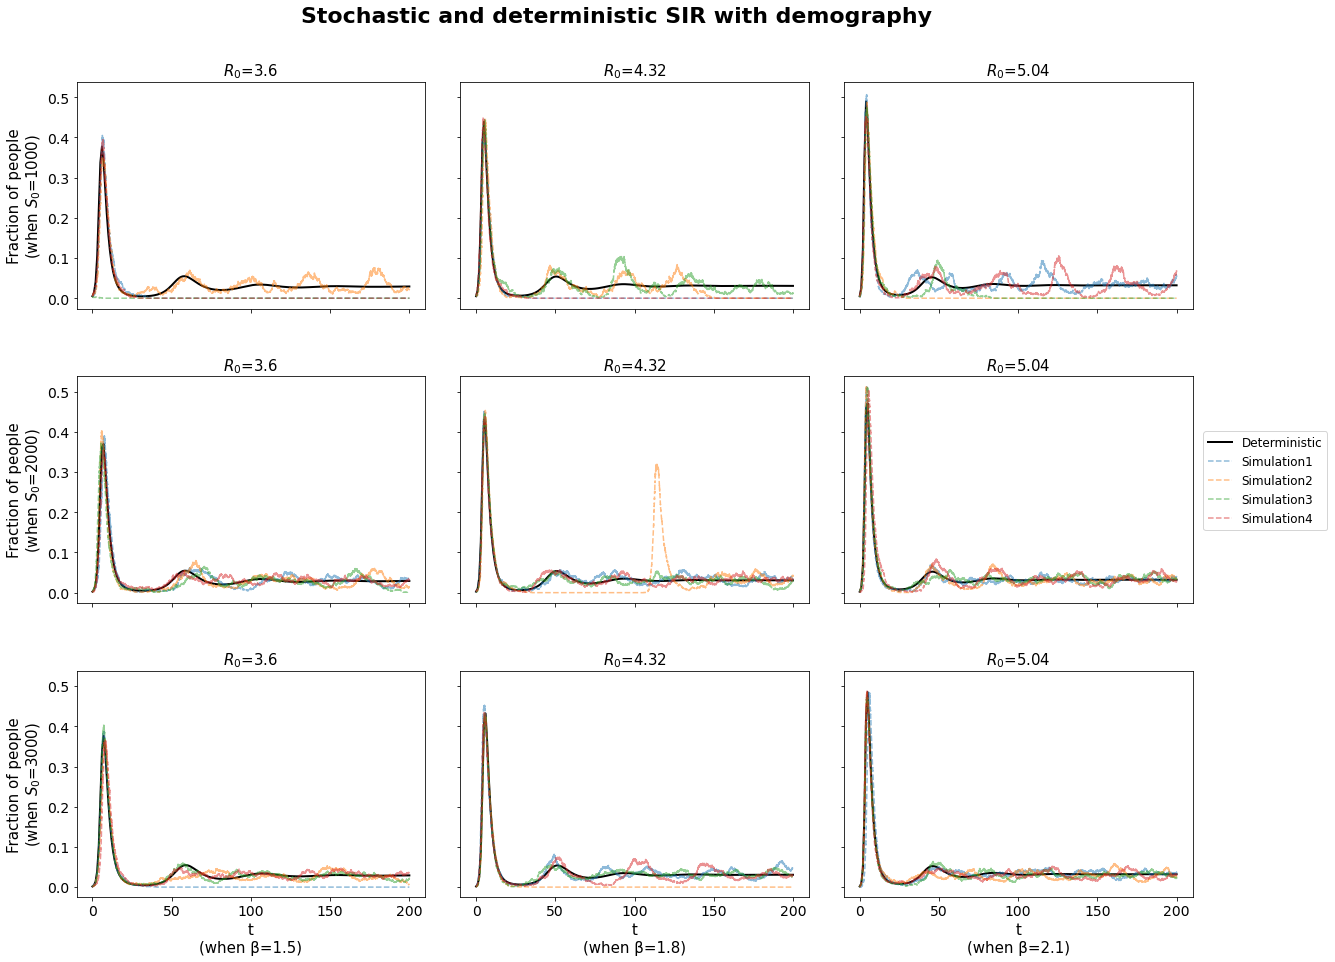

In [63]:
# Build the SIR model with demograhy
def SIR_demography_deterministic(y,t,beta,gamma,mu,N):
    S, I, R = y
    dSdt = mu*N - beta*S*I/N - mu*S
    dIdt = beta*S*I/N-mu*I-gamma*I
    dRdt = gamma*I-mu*R
    return [dSdt,dIdt,dRdt]

# Set the initial values
S0_list = [1000, 2000, 3000] 
I0 =  5
R0_r = 0
beta = [1.5, 1.8, 2.1]
gamma = 0.4
mu = 1/60
epsilon = 0.001
t = np.linspace(0,200,201)
t_stop = 200

# Plot all combinations of beta and mu into the model
fig,ax=plt.subplots(nrows=len(S0_list),ncols=len(beta),sharex=True,sharey=True,figsize=(20,15))
for i in range(len(S0_list)):
    for j in range(len(beta)):
        N = S0_list[i] + I0 + R0_r
        result1=odeint(SIR_demography_deterministic,[S0_list[i],I0,R0],t,args=(beta[j],gamma,mu,N))
        R0 = beta[j]/(gamma+mu)
        ax[i,j].figsize=(3,3)
        ax[i,j].plot(t, [m/N for m in result1[:,1]], alpha=1, color='black', lw = 2) 

        # Plot stochastic model
        for k in range(4):
            results2 = SIR_demography(S0_list[i], I0, R0_r, beta[j], gamma, mu, epsilon, t_stop).events()
            ax[i,j].plot(results2[0],[n/N for n in results2[2]] , linestyle='--', alpha=0.5, label="Infectious")

        ax[i,j].set_title('$R_0$='+str(round(R0,2)),fontsize=15)
        ax[2,j].set_xlabel('t'+'\n(when '+ chr(946)+'='+str(beta[j])+')',fontsize=15)
        ax[i,0].set_ylabel('Fraction of people'+'\n(when '+ '$S_0$'+'='+str(round(S0_list[i],4))+')',fontsize=15)
        ax[i,j].tick_params(labelsize=14)

plt.subplots_adjust(hspace=0.3,wspace=0.1)
fig.legend(labels=['Deterministic','Simulation1','Simulation2','Simulation3','Simulation4'],loc="right",borderaxespad=0.7,fontsize=12)
fig.suptitle('Stochastic and deterministic SIR with demography',y=0.95,weight='bold',fontsize=22)
plt.savefig('e_3.jpg',dpi=300)

### 1.3.2 Negative co-variances

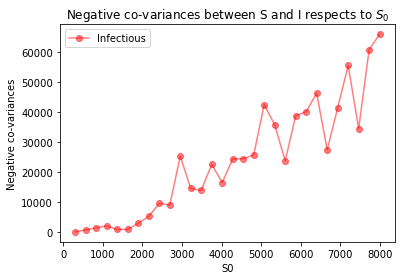

In [66]:
# Set the initial values
S0_list = np.linspace(300,8000,30)
I0 = 5
R0 = 0
beta = 1.4
gamma = 0.3
mu=1/60
epsilon = 0.001
t_stop = 30
results1=[]
# Operate class function
for i in S0_list:
    results=SIR_demography(i,I0,R0,beta,gamma, mu, epsilon, t_stop).events()
    results1.append(np.cov(results[1],results[2])[0][1])

plt.plot(S0_list,results1,'-o', c="r", alpha=0.5, label="Infectious")

# Plot SIR model
plt.xlabel("S0")
plt.ylabel("Negative co-variances")
plt.legend()
plt.title("Negative co-variances between S and I respects to $S_0$")
plt.savefig('e_4.jpg',dpi=200)
# plt.savefig('e_5.jpg',dpi=200) # when t_stop = 150
plt.show()

### 1.3.2 Increased transients

No handles with labels found to put in legend.


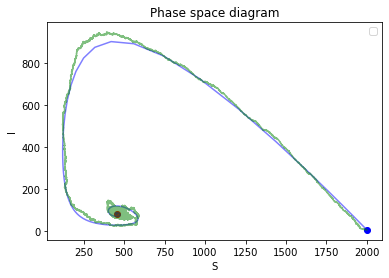

In [69]:
# Build the SIR model with demograhy
def SIR_demography_deterministic(y,t,beta,gamma,mu,N):
    S, I, R = y
    dSdt = mu*N - beta*S*I/N - mu*S
    dIdt = beta*S*I/N-mu*I-gamma*I
    dRdt = gamma*I-mu*R
    return [dSdt,dIdt,dRdt]

# Set the initial values
S0 = 2000
I0 = 5
R0_r = 0
beta = 1.4
gamma = 0.3
mu=1/60
epsilon = 0.001
t=np.linspace(0,200,400)
t_stop = 200

# Deterministic model
N = S0 + I0 + R0_r
R0 = beta/(gamma+mu)
S_fix = 1/R0                 # Get the fixed point
I_fix = mu*(R0-1)/beta
R_fix = 1-1/R0-mu*(R0-1)/beta              
results1 = odeint(SIR_demography_deterministic,[S0,I0,R0_r],t,args=(beta,gamma,mu,N)).T    
plt.plot(results1[0], results1[1],'blue',alpha=0.5) 
plt.scatter(S0,N-S0,c='blue')

# Stochasitc model
results2=SIR_demography(S0,I0,R0,beta,gamma, mu, epsilon, t_stop).events()
plt.plot(results2[1], results2[2],'green',alpha=0.5)

           
plt.scatter(S_fix*N,I_fix*N,c='red', marker='o')
plt.xlabel("S")
plt.ylabel("I")
plt.title("Phase space diagram")
plt.legend()
plt.savefig('e_6.jpg',dpi=200)
plt.show()

### 1.3.2 Stochastic resonance

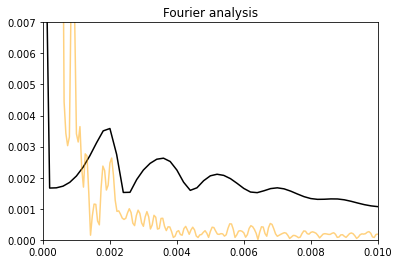

In [71]:
# Build the SIR model with demograhy
def SIR_demography_deterministic(y,t,beta,gamma,mu,N):
    S, I, R = y
    dSdt = mu*N - beta*S*I/N - mu*S
    dIdt = beta*S*I/N-mu*I-gamma*I
    dRdt = gamma*I-mu*R
    return [dSdt,dIdt,dRdt]

def Fourier(t, y):
    N1=len(t)                        
    x_fre= fftfreq(len(y))  # Get the frequency
    x_half=x_fre[range(int(N1/2))]      # Because of symmetry, half the interval
    y_f=fft(y)              # Fast Fourier transform
    y_abs=np.abs(y_f)                   # Get the absolute value
    y_normalization=y_abs/N1            # Normalization processing
    y_normalization_half=y_normalization[range(int(N1/2))]   # Half the interval  
    return [x_half,y_normalization_half]

# Set the initial values
S0 = 1000
I0 = 5
R0_r = 0
N = S0 + I0 + R0_r
beta = 1.9
gamma = 0.7
mu=1/60
epsilon = 0.01
t=np.linspace(0,500,5000)
t_stop = 500

# Deterministic
results1 = odeint(SIR_demography_deterministic,[S0,I0,R0_r],t,args=(beta,gamma,mu,N)).T
results2 = Fourier(t,[m/N for m in results1[1]]) 

# Stochastic
results3 = SIR_demography(S0,I0, R0_r, beta, gamma, mu, epsilon, t_stop).events()
results4 = Fourier(t,[n/N for n in results3[2]])

plt.plot(results2[0], results2[1],'black')
plt.plot(results4[0],results4[1],'orange',alpha=0.5)
plt.xlim(0,0.01)
plt.ylim(0,0.007)
plt.title("Fourier analysis")
plt.savefig('e_7.jpg',dpi=200)
plt.show()

### 1.3.2 Extinctions

No handles with labels found to put in legend.


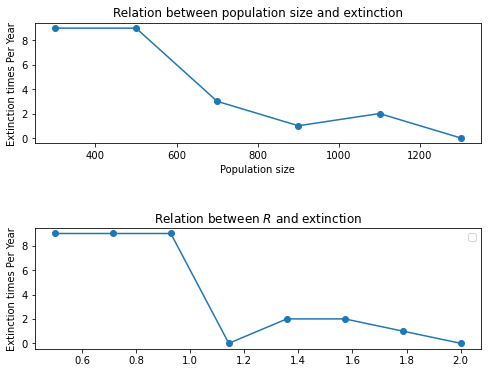

In [73]:
# Set the initial values
S0_list = np.arange(300,1500,200)
I0 = 5
R0_r = 0
beta = 1.4
gamma = 0.3
mu=1/60
epsilon = 0
t_stop = 365
times_total1 = []
times_total2 = []

# Explore the population size
for i in S0_list:
    times = 0
    for j in range(10):

        # Stochasitc model
        results = SIR_demography(i,I0, R0_r, beta, gamma, mu, epsilon, t_stop).events()
        for k in results[2]:
            if k == 0:
                times = times + 1
                break
    times_total1.append(times)

# Explore the R0
beta_list = np.linspace(0.5, 2, 8)
for i in beta_list:
    times = 0
    for j in range(10):

        # Stochasitc model
        results = SIR_demography(1000, I0, R0_r, i, gamma, mu, epsilon, t_stop).events()
        for k in results[2]:
            if k == 0:
                times = times + 1
                break
    times_total2.append(times)


fig, ax = plt.subplots(2, 1, figsize = [8, 6])
ax[0].plot(S0_list, times_total1,'-o')
ax[1].plot(beta_list, times_total2,'-o')
fig.subplots_adjust(hspace = 0.7, wspace = 0.2)
ax[0].set_xlabel("Population size")
ax[0].set_ylabel("Extinction times Per Year")
ax[0].set_title("Relation between population size and extinction")
ax[1].set_ylabel("Extinction times Per Year")
ax[1].set_title("Relation between $R\0$ and extinction")
plt.legend()
plt.savefig('e_8.jpg',dpi=200)
# plt.show()

### 1.3.2 Advanced topic:
 The first passage time


No handles with labels found to put in legend.


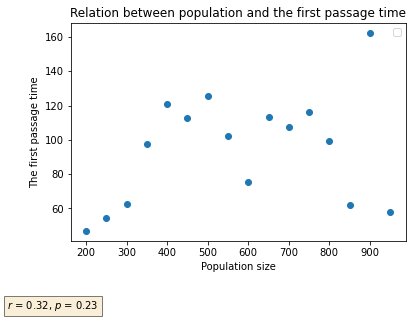

In [98]:
# Set the initial values
S0_list = np.arange(200,1000,50)
I0 = 5
R0_r = 0
beta = 1.4
gamma = 0.3
mu=1/60  
epsilon = 0
t_stop = 365
times_total = []

for i in S0_list:
    n = 0
    times = 0
    
    for j in range(30):
        
        # Stochasitc model
        results = SIR_demography(i, I0, R0_r, beta, gamma, mu, epsilon, t_stop).events()
        for k in range(len(results[2])):
            if results[2][k] == 0:
                times = times + results[0][k]
                n = n + 1
                break

    if n != 0:
        times = times / n
        times_total.append(times)
        
    elif n == 0:
        times_total.append(0)

r1, p1 = stats.pearsonr(S0_list, times_total) 
plt.scatter(S0_list, times_total)
plt.text(6,1.5, "$r$ = " + str(round(r1, 2)) + ", $p$ = " + str(round(p1, 2)), bbox = dict(boxstyle = "square", facecolor = 'wheat', edgecolor = 'black', alpha = 0.5),fontsize = 10)
plt.xlabel("Population size")
plt.ylabel("The first passage time")
plt.title("Relation between population and the first passage time")

plt.legend()
plt.savefig('e_9.jpg',dpi=200)
# plt.show()

# Problem 2: Spatial Models
## 2.1 Meta-population model
### 2.1.1 Build meta-population model with two sub populations:
The force of infection for $sub-population_i$ is: $\lambda_{i}=\beta_{i} \sum_{j} \rho_{i j} \frac{I_{j}}{N_{i}}$

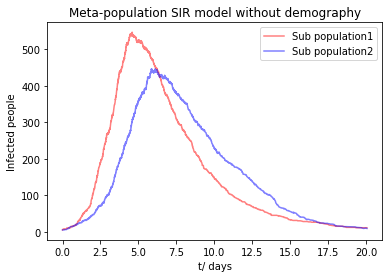

In [99]:
# Build metapopulation SIR model as class

class SIR_meta(object):

    # Set the initial parameters
    def __init__(self, S0, I0, R0, beta, gamma, rho, t_stop):
        self.S, self.I, self.R, self.N, self.t, self.lambd, self.rate_i, self.rate_r = [], [], [], [], [], [], [], []
        for i in range(len(S0)):
            self.S.append([S0[i]]),self.I.append([I0[i]]),self.R.append([R0[i]])
            self.N.append([S0[i] + I0[i] + R0[i]])
            self.lambd.append(0)
            self.rate_i.append(0)
            self.rate_r.append(0)
        self.t.append(0)
    
    # Simulate random events happening
    def events(self):
        while self.t[-1] < t_stop:
            SIR_meta.total_population(self)
            SIR_meta.create_lambda(self)
            rate_i, rate_r, rate_total = SIR_meta.rates(self)

            if rate_total == 0:
                break
            ran1, ran2 = np.random.uniform(0,1), np.random.uniform(0,1) * rate_total
            t_step = -math.log(ran1) / rate_total
            self.t.append(self.t[-1] + t_step)

            if ran2 < rate_i[0]:
                # Event 1: Group1 infection 
                SIR_meta.events_stay(self)
                self.S[0][-1] -= 1 
                self.I[0][-1] += 1
            elif ran2 < rate_i[0] + rate_i[1]:
                # Event 2: Group2 infection         
                SIR_meta.events_stay(self)
                self.S[1][-1] -= 1 
                self.I[1][-1] += 1
            elif ran2 < rate_i[0] + rate_i[1] + rate_r[0]:
                # Event 3: Group1 recovery
                SIR_meta.events_stay(self)
                self.I[0][-1] -= 1 
                self.R[0][-1] += 1
            else:
                # Event 4: Group2 recovery
                SIR_meta.events_stay(self)
                self.I[1][-1] -= 1 
                self.R[1][-1] += 1

        return [self.t,self.S,self.I,self.R]

    def total_population(self):
        for i in range(len(S0)):
            self.N[i].append(self.S[i][-1]+self.I[i][-1]+self.R[i][-1])

    def create_lambda(self):
        for i in range(len(S0)):
            value = 0
            for j in range(len(S0)):
                value = value + beta * rho[i][j] * self.I[j][-1] / self.N[i][-1]
            self.lambd[i] = value
        
    def rates(self):
        rate_total = 0
        for i in range(len(S0)):
            self.rate_i[i] = self.lambd[i] * self.S[i][-1] 
            self.rate_r[i] = gamma * self.I[i][-1]
            rate_total = rate_total + self.rate_i[i] + self.rate_r[i]
        return self.rate_i, self.rate_r, rate_total

    def events_stay(self):
        for i in range(len(S0)):      
            self.S[i].append(self.S[i][-1])
            self.I[i].append(self.I[i][-1])
            self.R[i].append(self.R[i][-1])

# Set the initial values
S0 = [995, 995]
I0 = [5, 5]
R0 = [0, 0]

beta = 1.4
gamma = 0.3
rho = [[1, 0.3],[0, 1]]
t_stop = 20

# Operate class function
results = SIR_meta(S0, I0, R0, beta, gamma, rho, t_stop).events()

# Plot basic SIR model
plt.plot(results[0], results[2][0], c = "r", alpha = 0.5, label = "Sub population1")
plt.plot(results[0], results[2][1], c = "b", alpha = 0.5, label = "Sub population2")
plt.legend()
plt.xlabel("t/ days")
plt.ylabel("Infected people")
plt.title("Meta-population SIR model without demography")
plt.savefig('m_1.jpg',dpi=200)
plt.show()

### 2.1.2 Test the impact of different $\rho$ on sub population 1:

In [ ]:
# Set the initial values
S0 = [995, 995]
I0 = [5, 5]
R0 = [0, 0]

beta = 1.4
gamma = 0.3
rho = [[1, 0], [0, 1]]
rho_list = np.linspace(0.1, 0.9, 9)
t_stop = 20

# Adjust the line color
def  Color_Normalization(x,inp_list):
    x=x/np.average(inp_list)
    return x/16

# Operate class function
for i in range(len(rho_list)):
    rho[0][1] = rho_list[i]
    results = SIR_meta(S0, I0, R0, beta, gamma, rho, t_stop).events()
    plt.plot(results[0], results[2][0], alpha = 0.9, color = plt.cm.RdYlBu(0.92-Color_Normalization(i,rho_list)), label = chr(961) + ' = '+str(round(rho_list[i],2)))

plt.legend()
plt.xlabel("t/ days")
plt.ylabel("Infected People")
plt.title("Meta-population SIR model without demography")
plt.show()

### 2.1.2 Explore the delays and peak heights between two sub populations:

Use Pearson correlation coefficient analysis: caculate correlation coefficient and significance level (P-value).

For correlation coefficient:
| correlation | Negative | Positive |
| :--- | :---: | :--- |
| None | -0.09 to 0.0 | 0.0 to 0.09 |
| Weak | -0.3 to -0.1 | 0.1 to 0.3 |
| Medium | -0.5 to -0.3 | 0.3 to 0.5 |
| Strong | -1.0 to -0.5 | 0.5 to 1.0 |

For significance level:
If P-value is lower than the conventional 5% (P<0.05) the correlation coefficient is called statistically significant. If it is less than 0.01, it is more significant; for example, p value = 0.001, which is a very high significance level.

In [ ]:
# Set the initial values
S0 = [995, 995]
I0 = [5, 5]
R0 = [0, 0]
beta = 1.4
gamma = 0.3
rho = [[1, 0], [0, 1]]
rho_list = np.linspace(0.1, 0.9, 50)
t_stop = 20
delays = []
heights = []

# Find the peaks and delays
fig,ax = plt.subplots(nrows = 2,ncols = 1,sharex=True,figsize=(8,6))
for i in range(len(rho_list)):
    rho[0][1] = rho_list[i]
    results = SIR_meta(S0, I0, R0, beta, gamma, rho, t_stop).events()
    peak1_index = results[2][0].index(max(results[2][0]))
    peak2_index = results[2][1].index(max(results[2][1]))
    delay = results[0][peak1_index] - results[0][peak2_index]
    height = results[2][0][peak1_index] - results[2][1][peak2_index]
    delays.append(delay)
    heights.append(height)

# Caculate correlation coefficient (r) and significance level (p)
r1, p1 = stats.pearsonr(rho_list, delays)   
r2, p2 = stats.pearsonr(rho_list, heights)  

# Plot data
ax[0].figsize=(5,4) 
ax[1].figsize=(5,4) 
ax[0].plot(rho_list, delays, '-o', alpha = 0.9, label = 'Delay' + '\n' + '(r = '+ str(round(r1, 2))+'\n'+'p = ' + str(round(p1, 2)) + ')')
ax[1].plot(rho_list, heights, '-o', alpha = 0.9, label = 'Difference' + '\n' + '(r = '+ str(round(r2, 2))+'\n'+'p = ' + str(round(p2, 2)) + ')')
ax[0].set_title("Peaks' delays between two sub populations" + '\n' + " (" + 'sub populations1 - sub populations2' + ")")
ax[1].set_title('Differences between two peaks')
ax[1].set_xlabel(chr(961))
ax[0].set_ylabel('Time')
ax[1].set_ylabel('Infected people')
ax[0].legend(loc = 'upper right')
ax[1].legend(loc = 'upper left')
fig.subplots_adjust(hspace = 0.3)
fig.suptitle('Meta-population SIR model', y= 1.05, weight='bold', fontsize=12)


 ### 2.1.3 More sub populations


In [ ]:
class SIR_meta(object):

    # Set the initial parameters
    def __init__(self, S0, I0, R0, beta, gamma, rho, t_stop):
        self.S, self.I, self.R, self.N, self.t, self.lambd, self.rate_i, self.rate_r = [], [], [], [], [], [], [], []
        for i in range(len(S0)):
            self.S.append([S0[i]]),self.I.append([I0[i]]),self.R.append([R0[i]])
            self.N.append([S0[i] + I0[i] + R0[i]])
            self.lambd.append(0)
            self.rate_i.append(0)
            self.rate_r.append(0)
        self.t.append(0)
    
    # Simulate random events happening
    def events(self):
        while self.t[-1] < t_stop:
            SIR_meta.total_population(self)
            SIR_meta.create_lambda(self)
            rate_i, rate_r, rate_total = SIR_meta.rates(self)

            if rate_total == 0:
                break
            ran1, ran2 = np.random.uniform(0,1), np.random.uniform(0,1) * rate_total
            t_step = -math.log(ran1) / rate_total
            self.t.append(self.t[-1] + t_step)

            if ran2 < rate_i[0]:
                # Event 1: Group1 infection 
                SIR_meta.events_stay(self)
                self.S[0][-1] -= 1 
                self.I[0][-1] += 1
            elif ran2 < rate_i[0] + rate_r[0]:
                # Event 2: Group1 recovery        
                SIR_meta.events_stay(self)
                self.I[0][-1] -= 1 
                self.R[0][-1] += 1
            elif ran2 < rate_i[0] + rate_r[0] + rate_i[1]:
                # Event 3: Group2 infection
                SIR_meta.events_stay(self)
                self.S[1][-1] -= 1 
                self.I[1][-1] += 1
            elif ran2 < rate_i[0] + rate_r[0] + rate_i[1] + rate_r[1]:
                # Event 4: Group2 recovery
                SIR_meta.events_stay(self)
                self.I[1][-1] -= 1 
                self.R[1][-1] += 1
            elif ran2 < rate_i[0] + rate_r[0] + rate_i[1] + rate_r[1] + rate_i[2]:
                # Event 5: Group3 infection
                SIR_meta.events_stay(self)
                self.S[2][-1] -= 1 
                self.I[2][-1] += 1
            elif ran2 < rate_i[0] + rate_r[0] + rate_i[1] + rate_r[1] + rate_i[2] + rate_r[2]:
                # Event 6: Group3 recovery
                SIR_meta.events_stay(self)
                self.I[2][-1] -= 1 
                self.R[2][-1] += 1
            elif ran2 < rate_i[0] + rate_r[0] + rate_i[1] + rate_r[1] + rate_i[2] + rate_r[2] + rate_i[3]:
                # Event 7: Group4 infection
                SIR_meta.events_stay(self)
                self.S[3][-1] -= 1 
                self.I[3][-1] += 1
            elif ran2 < rate_i[0] + rate_r[0] + rate_i[1] + rate_r[1] + rate_i[2] + rate_r[2] + rate_i[3] + rate_r[3]:
                # Event 8: Group4 recovery
                SIR_meta.events_stay(self)
                self.I[3][-1] -= 1 
                self.R[3][-1] += 1
            elif ran2 < rate_i[0] + rate_r[0] + rate_i[1] + rate_r[1] + rate_i[2] + rate_r[2] + rate_i[3] + rate_r[3] + rate_i[4]:
                # Event 9: Group5 infection
                SIR_meta.events_stay(self)
                self.S[4][-1] -= 1 
                self.I[4][-1] += 1
            else:
                # Event 10: Group5 recovery
                SIR_meta.events_stay(self)
                self.I[4][-1] -= 1 
                self.R[4][-1] += 1

        return [self.t,self.S,self.I,self.R]

    def total_population(self):
        for i in range(len(S0)):
            self.N[i].append(self.S[i][-1]+self.I[i][-1]+self.R[i][-1])

    def create_lambda(self):
        for i in range(len(S0)):
            value = 0
            for j in range(len(S0)):
                value = value + beta * rho[i][j] * self.I[j][-1] / self.N[i][-1]
            self.lambd[i] = value
        
    def rates(self):
        rate_total = 0
        for i in range(len(S0)):
            self.rate_i[i] = self.lambd[i] * self.S[i][-1] 
            self.rate_r[i] = gamma * self.I[i][-1]
            rate_total = rate_total + self.rate_i[i] + self.rate_r[i]
        return self.rate_i, self.rate_r, rate_total

    def events_stay(self):
        for i in range(len(S0)):      
            self.S[i].append(self.S[i][-1])
            self.I[i].append(self.I[i][-1])
            self.R[i].append(self.R[i][-1])

# Set the initial values
S0 = [995, 995, 995, 995, 995]
I0 = [5, 5, 5, 5, 5]
R0 = [0, 0, 0, 0, 0]
beta = 1.4
gamma = 0.3
rho = [[1, 0.15, 0.18, 0.2, 0.34], 
[0, 1, 0, 0, 0], 
[0, 0, 1, 0, 0], 
[0, 0, 0, 1, 0], 
[0, 0, 0, 0, 1]]
t_stop = 20

# Operate class function
results = SIR_meta(S0, I0, R0, beta, gamma, rho, t_stop).events()

# Plot basic SIR model
plt.plot(results[0], results[2][0], c = "r", alpha = 0.5, label = "Sub population1")
plt.plot(results[0], results[2][1], c = "b", alpha = 0.5, label = "Sub population2")
plt.plot(results[0], results[2][2], c = "g", alpha = 0.5, label = "Sub population3")
plt.plot(results[0], results[2][3], c = "y", alpha = 0.5, label = "Sub population4")
plt.plot(results[0], results[2][4], c = "black", alpha = 0.5, label = "Sub population5")
plt.legend()
plt.xlabel("t/ days")
plt.ylabel("Infected people")
plt.title("SIR model with five meta-populations")
plt.show()

## 2.2 Network model and Vaccines
### 2.2.1 Assess the impact of the epidemic:

All models of NDlib assume an agent-based, discrete-time, simulation engine.
During each iteration all the nodes in the network are asked to

1. Evaluate their current status and to
2. (eventually) apply a matching transition rule. So, the higher the degree of a node, the more likely that it becomes infected.

<br>``Ndlib`` breaks the simulation of diffusive phenomena into a standard workflow:
- Network Creation
- Diffusion model Selection
- Simulation execution
- Results visualisation


References: 

G. Rossetti, L. Milli, S. Rinzivillo, A. Sirbu, D. Pedreschi, F. Giannotti. “NDlib: a Python Library to Model and Analyze Diffusion Processes Over Complex Networks” Journal of Data Science and Analytics. 2017. DOI:0.1007/s41060-017-0086-6 (pre-print available on arXiv)

G. Rossetti, L. Milli, S. Rinzivillo, A. Sirbu, D. Pedreschi, F. Giannotti. “NDlib: Studying Network Diffusion Dynamics” IEEE International Conference on Data Science and Advanced Analytics, DSAA. 2017.


Text(0, 0.5, 'People')

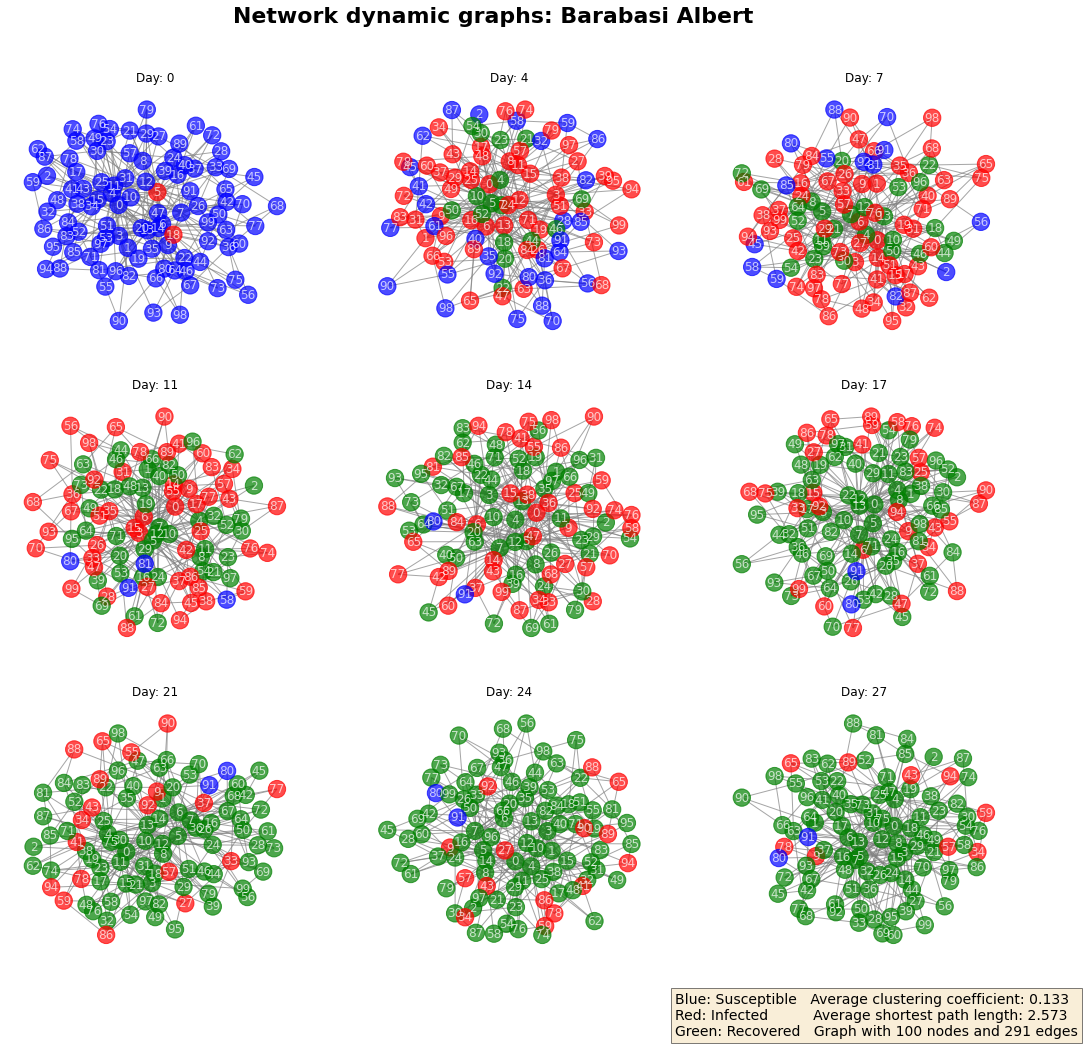

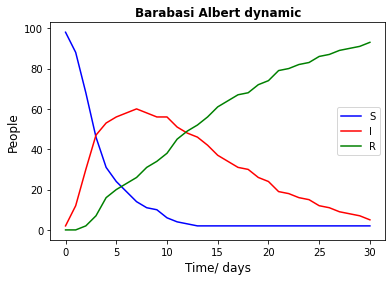

In [34]:
class Network_SIRmodel(object):

    # Set the initial parameters
    def __init__(self, g, graph_name, beta, gamma, End_day):
        self.g = g
        self.beta = beta
        self.gamma = gamma
        self.color_dict = {'S':'b', 'I':'r', 'R':'g'} 
        
    # Update the condition of single node
    def update_node(self, node):
        R = np.random.uniform(0,1)              # Generate a ramdom number R from 0 to 1
        if self.g.nodes[node]['state'] == 'S': 
            # Condition1: Susceptible
            neighbors_infected = 0        # Count how many neighbors infected
            for i in self.g.adj[node]: 
                if self.g.nodes[i]['state'] == 'I': 
                    neighbors_infected += 1
            if R < 1 - (1 - beta)**neighbors_infected:  # This node: S -> I
                self.g.nodes[node]['state'] = 'I'  
        elif self.g.nodes[node]['state'] == 'I':  
            # Condition2: Infected
            if R < gamma:   
                self.g.nodes[node]['state'] = 'R' 
        
    # Update the whole network
    def update_network(self):
        for node in self.g: 
            Network_SIRmodel.update_node(self, node)  
       
    # Count the total number of S, I , and R
    def count(self):
        self.S = 0; self.I = 0; self.R = 0
        for node in self.g:
            if self.g.nodes[node]['state'] == 'S':
                self.S += 1
            elif self.g.nodes[node]['state'] == 'I':
                self.I += 1
            else :
                self.R += 1
        return [self.S, self.I, self.R]   

    # Adjust the node color
    def node_color(self):   
        self.color_list = []  
        for node in self.g:
            self.color_list.append(self.color_dict[self.g.nodes[node]['state']])
        return self.color_list  

    # Caculate all results of SIR dynamics
    def dynamics(self):
        # Count the initial number of SIR
        results = []
        results.append(G.count())
        for t in range(0, End_day):
            G.update_network()           # Update network
            results.append(G.count())    # Count S, I, and R number
        return results

    # Draw nines graphs happened evenly in whole process, and give the data of SIR dynamics
    def draw_graphs(self):
        # Count the initial number of SIR
        results = []
        results.append(G.count())
        fig= plt.subplots(3, 3,figsize=(18, 16))
        for t in range(0, End_day):
            # Plot nine graphs as even time interval through the whole period
            if int(t% (End_day / 9)) == 0:
                plt.subplot(331 + int(t / (End_day / 9)))
                plt.title('Day: ' + str(t))
                nx.draw(g, with_labels = True, font_color='white', alpha = 0.7,node_color = G.node_color(), edge_color = 'gray')
            G.update_network()           # Update network
            results.append(G.count())    # Count S, I, and R number
        # Adjust the whole image
        plt.suptitle('Network dynamic graphs: ' + graph_name, y=0.95, weight='bold', fontsize=22)
        plt.text(-1.5, -1.7, 'Blue: Susceptible   Average clustering coefficient: '+ str(round(nx.average_clustering(self.g), 3)) + '\n' + 'Red: Infected          Average shortest path length: ' + str(round(nx.average_shortest_path_length(self.g), 3))+'\n' + 'Green: Recovered   ' + nx.info(self.g),
        bbox=dict(boxstyle="square", facecolor='wheat', edgecolor='black', alpha= 0.5),fontsize=14)
        return results


'2.1.1.1 Scale-free networks: Barabasi Albert graph'

# Set the initial values
N = 100
beta = 0.2
gamma = 0.1
End_day = 30
# Scale-free networks: more vulnerable to attacks 
graph_name = 'Barabasi Albert'
g = nx.barabasi_albert_graph(N, 3, seed=2) 
# pos = nx.random_layout(g, seed = 26) 

# Set the condition for every node, and import the infected
for node in g:   
    g.nodes[node]['state'] = 'S'
g.nodes[5]['state'] = "I"     # Set infectious node
g.nodes[18]['state'] = 'I'

# Put the graph into class
G = Network_SIRmodel(g, graph_name, beta, gamma, End_day)

# Generate graphs and every steps dynamics data
results = G.draw_graphs()

# Analyse the trend dynamics
color_dict = {'S':'b','I':'r','R':'g'} 
ax = pd.DataFrame(results,columns=['S', 'I', 'R'])
ax.plot(color=[color_dict.get(x) for x in ax.columns])
plt.title('Barabasi Albert dynamic',weight='bold')
plt.xlabel('Time/ days', fontsize=12)
plt.ylabel('People', fontsize=12)
# print(nx.info(g),nx.average_clustering(g), nx.average_shortest_path_length(g),nx.degree_centrality(g))

Text(0, 0.5, 'People')

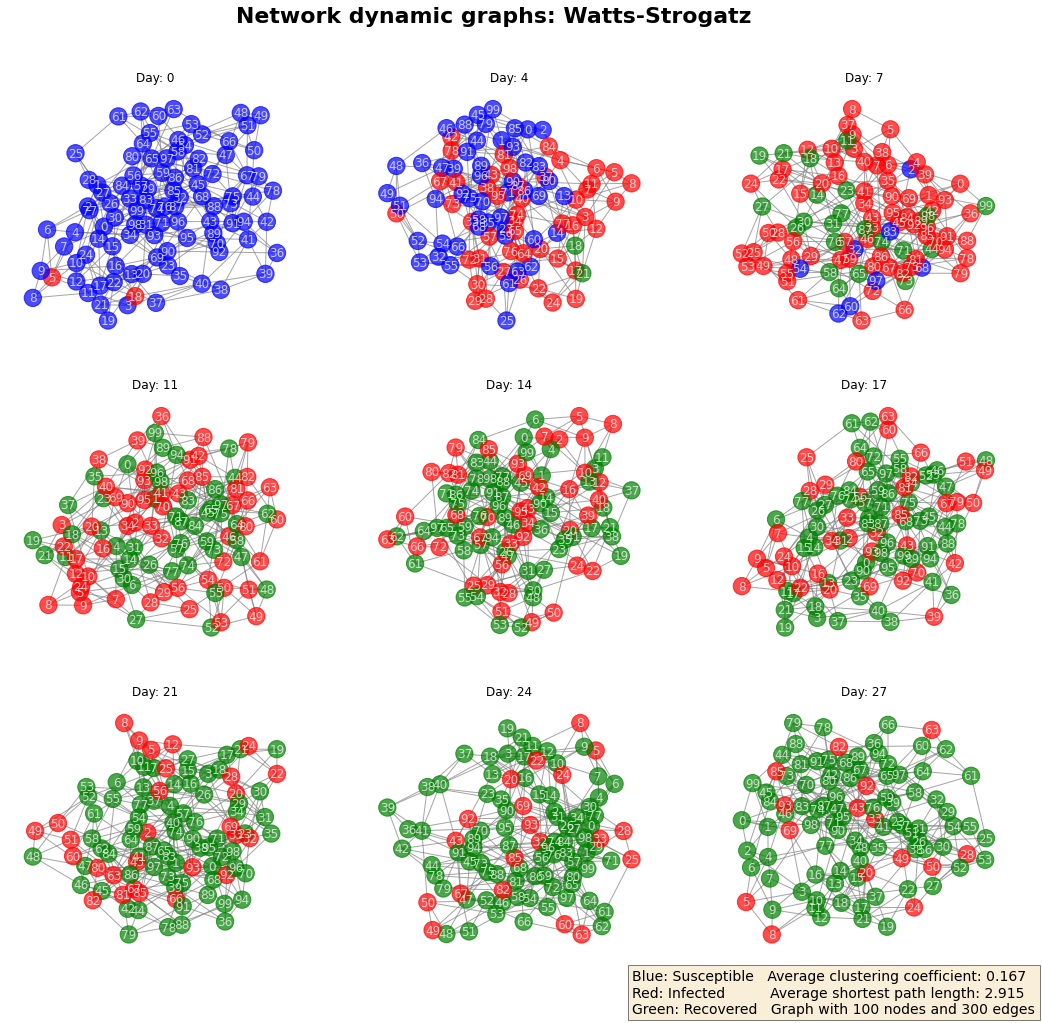

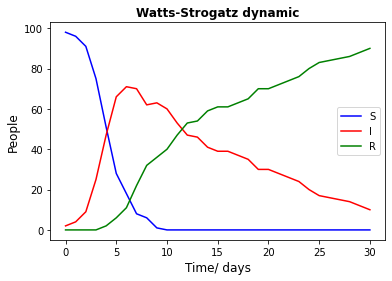

In [41]:
'2.1.1.2 Small World Networks: Watts-Strogatz graph'

# Set the initial values
N = 100
beta = 0.2
gamma = 0.1
End_day = 30
#  Small World Networks
graph_name = 'Watts-Strogatz'
g = nx.watts_strogatz_graph(N, 6, 0.4, seed=2) 
# pos = nx.random_layout(g, seed = 26) 

# Set the condition for every node, and import the infected
for node in g:   
    g.nodes[node]['state'] = 'S'
g.nodes[5]['state'] = "I"     # Set infectious node
g.nodes[18]['state'] = 'I'

# Put the graph into class
G = Network_SIRmodel(g, graph_name, beta, gamma, End_day)

# Generate graphs and every steps dynamics data
results = G.draw_graphs()

# Analyse the trend dynamics
color_dict = {'S':'b','I':'r','R':'g'} 
ax = pd.DataFrame(results,columns=['S', 'I', 'R'])
ax.plot(color=[color_dict.get(x) for x in ax.columns])
plt.title('Watts-Strogatz dynamic', weight='bold')
plt.xlabel('Time/ days', fontsize=12)
plt.ylabel('People', fontsize=12)
# print(nx.info(g), nx.average_clustering(g), nx.average_shortest_path_length(g))

Text(0, 0.5, 'People')

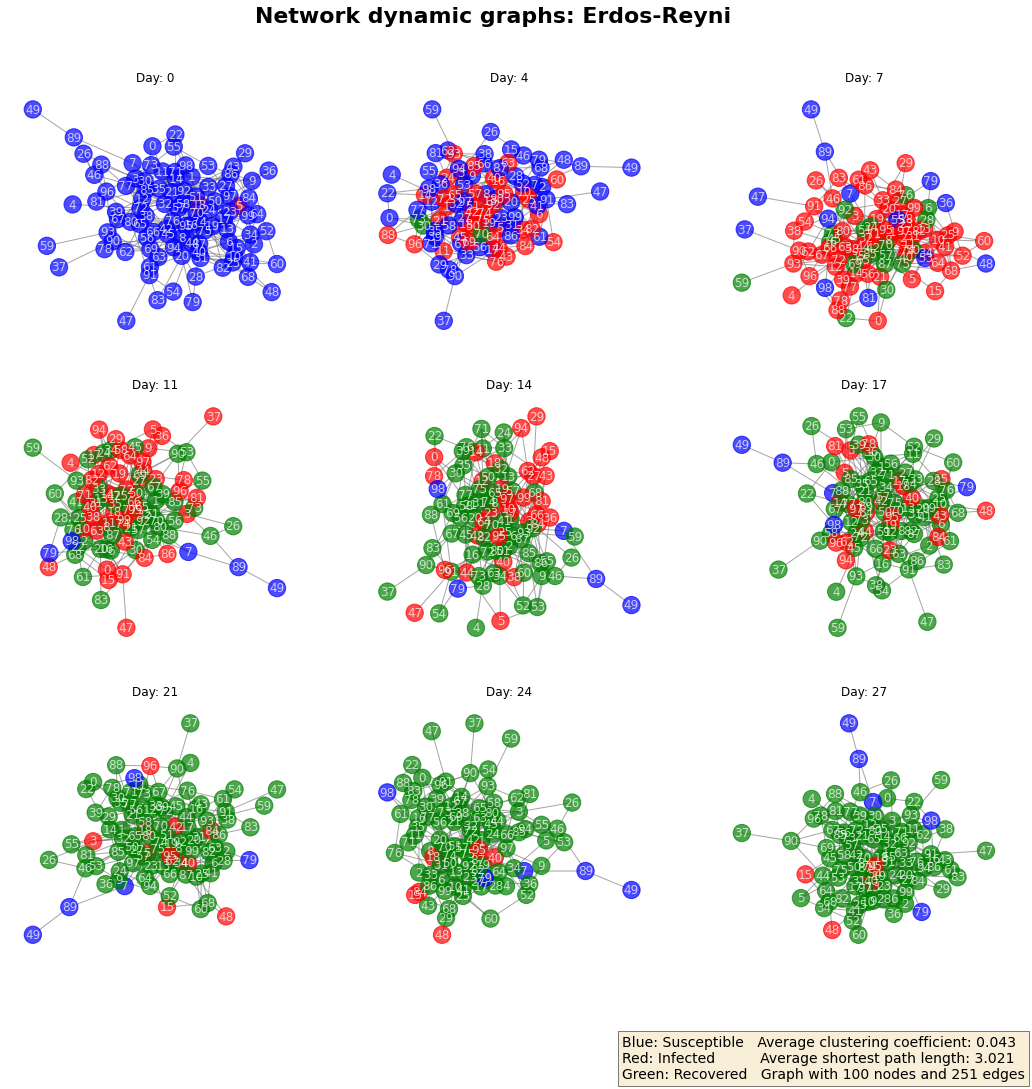

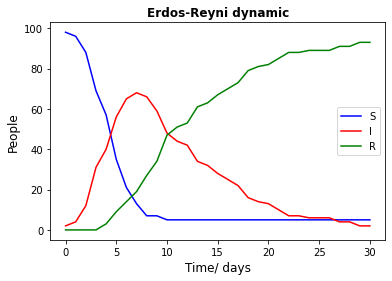

In [42]:
'2.1.1.3 Random Networks: Erdos-Reyni graph'

# Set the initial values
N = 100
beta = 0.2
gamma = 0.1
End_day = 30
graph_name = 'Erdos-Reyni'
# Random Networks: a random graph with N labeled nodes where each pair of nodes is connected by a preset probability p. The random network is therefore characterized by a lack of heterogeneity in the number of contacts and a lack of clustering.
g = nx.erdos_renyi_graph(N, 0.05, seed=2)  


# Set the condition for every node, and import the infected
for node in g:   
    g.nodes[node]['state'] = 'S'
g.nodes[5]['state'] = 'I'    # Set infectious node
g.nodes[18]['state'] = 'I'

# Put the graph into class
G = Network_SIRmodel(g, graph_name, beta, gamma, End_day)

# Generate graphs and every steps dynamics data
results = G.draw_graphs()

# Analyse the trend dynamics
color_dict = {'S':'b','I':'r','R':'g'} 
ax = pd.DataFrame(results,columns=['S', 'I', 'R'])
ax.plot(color=[color_dict.get(x) for x in ax.columns])
plt.title('Erdos-Reyni dynamic', weight='bold')
plt.xlabel('Time/ days', fontsize=12)
plt.ylabel('People', fontsize=12)
# print(nx.info(g), nx.average_clustering(g), nx.average_shortest_path_length(g) )

### 2.2.2 Vary disease initalisation:

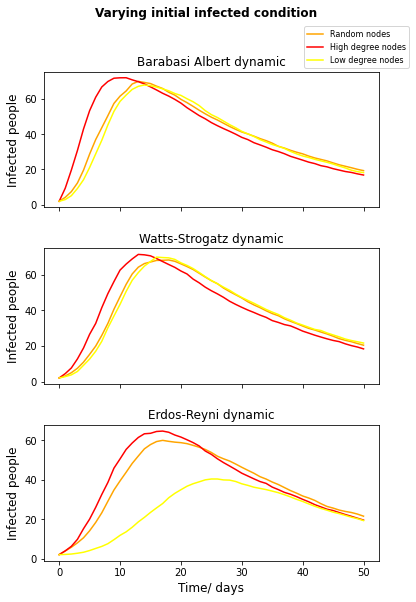

In [33]:
# Because the initial infectecd has the crucial influence on epidemic, we can vary the initial infected node on networks

# Set the initial values
N = 100
beta = 0.1
gamma = 0.04
End_day = 50
times = 30
graph_name1 = 'Barabasi Albert'
graph_name2 = 'Watts-Strogatz'
graph_name3 = 'Erdos-Reyni'

"1"""""""""""""""""""
########  Simulate multiple times random results and caculate the average trend ##########
results1 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random1 = np.random.randint(0, N)
    seed_random2 = np.random.randint(0, N)
    g = nx.barabasi_albert_graph(N, 3, seed = seed_random1) 

    # Set the condition for every node, and import the infected
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random1]['state'] = 'I'
    g.nodes[seed_random2]['state'] = 'I'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name1, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results,columns=['S', 'I', 'R'])
    results1 = results1.add(results)
results1['I'] = results1['I'] / times
###########################################################

########  Simulate multiple times highest results and caculate the average trend ########
results2 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random = np.random.randint(0, N)
    g = nx.barabasi_albert_graph(N, 3, seed = seed_random) 

    # Find the node with the highest degree
    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = False)
    # print(nodes_degree[0:5].to_string(index = False))

    # Set the node with the highest and second highest degree as the infected
    node_highest = int(nodes_degree.values[0,0])
    node_second_highest = int(nodes_degree.values[1,0])

    # Set the condition for every node, and import the infected
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[node_highest]['state'] = 'I'
    g.nodes[node_second_highest]['state'] = 'I'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name1, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results, columns=['S', 'I', 'R'])
    results2 = results2.add(results)
results2['I'] = results2['I'] / times
###########################################################

########  Simulate multiple times lowest results and caculate the average trend ########
results3 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random = np.random.randint(0, N)
    g = nx.barabasi_albert_graph(N, 3, seed = seed_random) 

    # Find the node with the lowest degree
    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = True)

    # Set the node with the lowest and second lowest degree as the infected
    node_lowest = int(nodes_degree.values[0,0])
    node_second_lowest = int(nodes_degree.values[1,0])

    # Set the condition for every node, and import the infected
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[node_lowest]['state'] = 'I'
    g.nodes[node_second_lowest]['state'] = 'I'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name1, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results, columns=['S', 'I', 'R'])
    results3 = results3.add(results)
results3['I'] = results3['I'] / times
###########################################################

"2"""""""""""""""""""""""""""""""""""""""""""

########  Simulate multiple times random results and caculate the average trend ##########
results4 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random1 = np.random.randint(0, N)
    seed_random2 = np.random.randint(0, N)
    g = nx.watts_strogatz_graph(N, 6, 0.4, seed = seed_random1) 

    # Set the condition for every node, and import the infected
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random1]['state'] = 'I'
    g.nodes[seed_random2]['state'] = 'I'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name2, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results,columns=['S', 'I', 'R'])
    results4 = results4.add(results)
results4['I'] = results4['I'] / times
###########################################################

########  Simulate multiple times highest results and caculate the average trend ########
results5 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random = np.random.randint(0, N)
    g = nx.watts_strogatz_graph(N, 6, 0.4, seed = seed_random) 

    # Find the node with the highest degree
    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = False)
    # print(nodes_degree[0:5].to_string(index = False))

    # Set the node with the highest and second highest degree as the infected
    node_highest = int(nodes_degree.values[0,0])
    node_second_highest = int(nodes_degree.values[1,0])

    # Set the condition for every node, and import the infected
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[node_highest]['state'] = 'I'
    g.nodes[node_second_highest]['state'] = 'I'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name2, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results, columns=['S', 'I', 'R'])
    results5 = results5.add(results)
results5['I'] = results5['I'] / times
###########################################################

########  Simulate multiple times lowest results and caculate the average trend ########
results6 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random = np.random.randint(0, N)
    g = nx.watts_strogatz_graph(N, 6, 0.4, seed = seed_random) 

    # Find the node with the lowest degree
    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = True)

    # Set the node with the lowest and second lowest degree as the infected
    node_lowest = int(nodes_degree.values[0,0])
    node_second_lowest = int(nodes_degree.values[1,0])

    # Set the condition for every node, and import the infected
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[node_lowest]['state'] = 'I'
    g.nodes[node_second_lowest]['state'] = 'I'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name2, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results, columns=['S', 'I', 'R'])
    results6 = results6.add(results)
results6['I'] = results6['I'] / times
###########################################################

"3"""""""""""""""""""""""""""""""""""""""""""

########  Simulate multiple times random results and caculate the average trend ##########
results7 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random1 = np.random.randint(0, N)
    seed_random2 = np.random.randint(0, N)
    g = nx.erdos_renyi_graph(N, 0.05, seed = seed_random1) 
    # Set the condition for every node, and import the infected
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random1]['state'] = 'I'
    g.nodes[seed_random2]['state'] = 'I'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name3, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results,columns=['S', 'I', 'R'])
    results7 = results7.add(results)
results7['I'] = results7['I'] / times
###########################################################

########  Simulate multiple times highest results and caculate the average trend ########
results8 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random = np.random.randint(0, N) 
    g = nx.erdos_renyi_graph(N, 0.05, seed = seed_random) 
    # Find the node with the highest degree
    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = False)
    # print(nodes_degree[0:5].to_string(index = False))

    # Set the node with the highest and second highest degree as the infected
    node_highest = int(nodes_degree.values[0,0])
    node_second_highest = int(nodes_degree.values[1,0])

    # Set the condition for every node, and import the infected
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[node_highest]['state'] = 'I'
    g.nodes[node_second_highest]['state'] = 'I'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name3, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results, columns=['S', 'I', 'R'])
    results8 = results8.add(results)
results8['I'] = results8['I'] / times
###########################################################

########  Simulate multiple times lowest results and caculate the average trend ########
results9 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random = np.random.randint(0, N)
    g = nx.erdos_renyi_graph(N, 0.05, seed = seed_random) 

    # Find the node with the lowest degree
    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = True)

    # Set the node with the lowest and second lowest degree as the infected
    node_lowest = int(nodes_degree.values[0,0])
    node_second_lowest = int(nodes_degree.values[1,0])

    # Set the condition for every node, and import the infected
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[node_lowest]['state'] = 'I'
    g.nodes[node_second_lowest]['state'] = 'I'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name3, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results, columns=['S', 'I', 'R'])
    results9 = results9.add(results)
results9['I'] = results9['I'] / times
###########################################################

# Analyse the trend dynamics
fig, ax = plt.subplots(nrows = 3, ncols = 1, sharex=True, figsize=(6,9))

ax[0].plot(results1['I'], color = 'orange', label = 'Random nodes')
ax[0].plot(results2['I'], color = 'red', label = 'High degree nodes')
ax[0].plot(results3['I'], color = 'yellow', label = 'Low degree nodes')
ax[0].set_title('Barabasi Albert dynamic')
ax[0].set_ylabel('Infected people', fontsize = 12)
ax[1].plot(results4['I'], color = 'orange')
ax[1].plot(results5['I'], color = 'red')
ax[1].plot(results6['I'], color = 'yellow')
ax[1].set_title('Watts-Strogatz dynamic')
ax[1].set_ylabel('Infected people', fontsize = 12)
ax[2].plot(results7['I'], color = 'orange')
ax[2].plot(results8['I'], color = 'red')
ax[2].plot(results9['I'], color = 'yellow')
ax[2].set_title('Erdos-Reyni dynamic')
ax[2].set_ylabel('Infected people', fontsize = 12)

fig.suptitle('Varying initial infected condition', weight='bold')
plt.xlabel('Time/ days', fontsize = 12)
plt.subplots_adjust(hspace=0.3,wspace=0.2)
fig.legend(loc = 'upper right', borderaxespad = 0, bbox_to_anchor=( 0.97, 0.95),fontsize = 8)
plt.show()


### 2.2.3 Vaccine strategy:

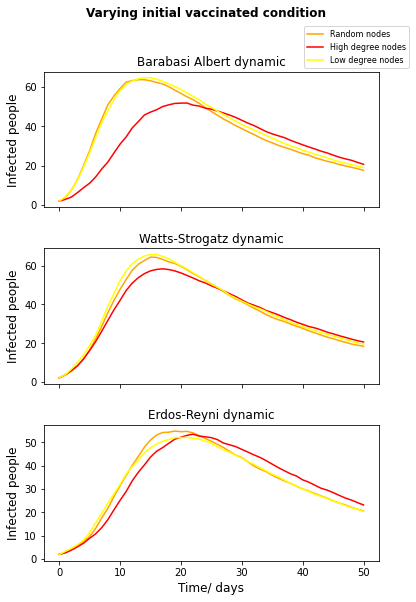

In [40]:
# Select the nodes with four random, highest degree, and lowest degree as initial vaccinated respectively. And import two infection randomly.

# Set the initial values
N = 100
beta = 0.1
gamma = 0.04
End_day = 50
times = 50
graph_name1 = 'Barabasi Albert'
graph_name2 = 'Watts-Strogatz'
graph_name3 = 'Erdos-Reyni'

"1"""""""""""""""""""
########  Simulate multiple times random results and caculate the average trend ##########
results1 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random1 = np.random.randint(0, N)
    seed_random2 = np.random.randint(0, N)
    seed_random3 = np.random.randint(0, N)
    seed_random4 = np.random.randint(0, N)
    seed_random5 = np.random.randint(0, N)
    seed_random6 = np.random.randint(0, N)
    g = nx.barabasi_albert_graph(N, 3, seed = seed_random1) 

    # Set the condition for every node, import the infected, and vaccinate
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random1]['state'] = 'I'
    g.nodes[seed_random2]['state'] = 'I'
    g.nodes[seed_random3]['state'] = 'R'
    g.nodes[seed_random4]['state'] = 'R'
    g.nodes[seed_random5]['state'] = 'R'
    g.nodes[seed_random6]['state'] = 'R'
    
    # Put the graph into class
    G = Network_SIRmodel(g, graph_name1, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results,columns=['S', 'I', 'R'])
    results1 = results1.add(results)
results1['I'] = results1['I'] / times
###########################################################

########  Simulate multiple times highest results and caculate the average trend ########
results2 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random1 = np.random.randint(0, N)
    seed_random2 = np.random.randint(0, N)
    seed_random3 = np.random.randint(0, N)
    g = nx.barabasi_albert_graph(N, 3, seed = seed_random1) 

    # Find the node with the highest degree
    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = False)
    # print(nodes_degree[0:5].to_string(index = False))

    # Set the node with the highest and second highest degree as the recovered
    node_highest = int(nodes_degree.values[0,0])
    node_second_highest = int(nodes_degree.values[1,0])
    node_third_highest = int(nodes_degree.values[2,0])
    node_fourth_highest = int(nodes_degree.values[3,0])

    # Set the condition for every node, import the infected, and vaccinate the nodes
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random2]['state'] = 'I'
    g.nodes[seed_random3]['state'] = 'I'
    g.nodes[node_highest]['state'] = 'R'
    g.nodes[node_second_highest]['state'] = 'R'
    g.nodes[node_third_highest]['state'] = 'R'
    g.nodes[node_fourth_highest]['state'] = 'R'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name1, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results, columns=['S', 'I', 'R'])
    results2 = results2.add(results)
results2['I'] = results2['I'] / times
###########################################################

########  Simulate multiple times lowest results and caculate the average trend ########
results3 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random1 = np.random.randint(0, N)
    seed_random2 = np.random.randint(0, N)
    seed_random3 = np.random.randint(0, N)
    g = nx.barabasi_albert_graph(N, 3, seed = seed_random1) 

    # Find the node with the lowest degree
    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = True)

    # Set the node with the lowest and second lowest degree as the recovered
    node_lowest = int(nodes_degree.values[0,0])
    node_second_lowest = int(nodes_degree.values[1,0])
    node_third_lowest = int(nodes_degree.values[2,0])
    node_fourth_lowest = int(nodes_degree.values[3,0])

    # Set the condition for every node, import the infected, and vaccinate the nodes
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random2]['state'] = 'I'
    g.nodes[seed_random3]['state'] = 'I'
    g.nodes[node_lowest]['state'] = 'R'
    g.nodes[node_second_lowest]['state'] = 'R'
    g.nodes[node_third_lowest]['state'] = 'R'
    g.nodes[node_fourth_lowest]['state'] = 'R'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name1, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results, columns=['S', 'I', 'R'])
    results3 = results3.add(results)
results3['I'] = results3['I'] / times
###########################################################

"2"""""""""""""""""""""""""""""""""""""""""""

########  Simulate multiple times random results and caculate the average trend ##########
results4 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random1 = np.random.randint(0, N)
    seed_random2 = np.random.randint(0, N)
    seed_random3 = np.random.randint(0, N)
    seed_random4 = np.random.randint(0, N)
    seed_random5 = np.random.randint(0, N)
    seed_random6 = np.random.randint(0, N)
    g = nx.watts_strogatz_graph(N, 6, 0.4, seed = seed_random1) 

    # Set the condition for every node, import the infected, and vaccinate
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random1]['state'] = 'I'
    g.nodes[seed_random2]['state'] = 'I'
    g.nodes[seed_random3]['state'] = 'R'
    g.nodes[seed_random4]['state'] = 'R'
    g.nodes[seed_random5]['state'] = 'R'
    g.nodes[seed_random6]['state'] = 'R'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name2, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results,columns=['S', 'I', 'R'])
    results4 = results4.add(results)
results4['I'] = results4['I'] / times
###########################################################

########  Simulate multiple times highest results and caculate the average trend ########
results5 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random1 = np.random.randint(0, N)
    seed_random2 = np.random.randint(0, N)
    seed_random3 = np.random.randint(0, N)
    g = nx.watts_strogatz_graph(N, 6, 0.4, seed = seed_random1) 

    # Find the node with the highest degree
    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = False)
    # print(nodes_degree[0:5].to_string(index = False))

    # Set the node with the highest and second highest degree as the infected
    node_highest = int(nodes_degree.values[0,0])
    node_second_highest = int(nodes_degree.values[1,0])
    node_third_highest = int(nodes_degree.values[2,0])
    node_fourth_highest = int(nodes_degree.values[3,0])

    # Set the condition for every node, import the infected, and vaccinate the nodes
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random2]['state'] = 'I'
    g.nodes[seed_random3]['state'] = 'I'
    g.nodes[node_highest]['state'] = 'R'
    g.nodes[node_second_highest]['state'] = 'R'
    g.nodes[node_third_highest]['state'] = 'R'
    g.nodes[node_fourth_highest]['state'] = 'R'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name2, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results, columns=['S', 'I', 'R'])
    results5 = results5.add(results)
results5['I'] = results5['I'] / times
###########################################################

########  Simulate multiple times lowest results and caculate the average trend ########
results6 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random = np.random.randint(0, N)
    g = nx.watts_strogatz_graph(N, 6, 0.4, seed = seed_random) 

    # Find the node with the lowest degree
    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = True)

    # Set the node with the lowest and second lowest degree as the infected
    node_lowest = int(nodes_degree.values[0,0])
    node_second_lowest = int(nodes_degree.values[1,0])
    node_third_lowest = int(nodes_degree.values[2,0])
    node_fourth_lowest = int(nodes_degree.values[3,0])

    # Set the condition for every node, import the infected, and vaccinate the nodes
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random2]['state'] = 'I'
    g.nodes[seed_random3]['state'] = 'I'
    g.nodes[node_lowest]['state'] = 'R'
    g.nodes[node_second_lowest]['state'] = 'R'
    g.nodes[node_third_lowest]['state'] = 'R'
    g.nodes[node_fourth_lowest]['state'] = 'R'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name2, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results, columns=['S', 'I', 'R'])
    results6 = results6.add(results)
results6['I'] = results6['I'] / times
###########################################################

"3"""""""""""""""""""""""""""""""""""""""""""

########  Simulate multiple times random results and caculate the average trend ##########
results7 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random1 = np.random.randint(0, N)
    seed_random2 = np.random.randint(0, N)
    seed_random3 = np.random.randint(0, N)
    seed_random4 = np.random.randint(0, N)
    seed_random5 = np.random.randint(0, N)
    seed_random6 = np.random.randint(0, N)
    g = nx.erdos_renyi_graph(N, 0.05, seed = seed_random1) 
    # Set the condition for every node, and import the infected
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random1]['state'] = 'I'
    g.nodes[seed_random2]['state'] = 'I'
    g.nodes[seed_random3]['state'] = 'R'
    g.nodes[seed_random4]['state'] = 'R'
    g.nodes[seed_random5]['state'] = 'R'
    g.nodes[seed_random6]['state'] = 'R'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name3, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results,columns=['S', 'I', 'R'])
    results7 = results7.add(results)
results7['I'] = results7['I'] / times
###########################################################

########  Simulate multiple times highest results and caculate the average trend ########
results8 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random1 = np.random.randint(0, N) 
    seed_random2 = np.random.randint(0, N)
    seed_random3 = np.random.randint(0, N)
    g = nx.erdos_renyi_graph(N, 0.05, seed = seed_random1) 
    # Find the node with the highest degree
    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = False)
    # print(nodes_degree[0:5].to_string(index = False))

    # Set the node with the highest and second highest degree as the infected
    node_highest = int(nodes_degree.values[0,0])
    node_second_highest = int(nodes_degree.values[1,0])
    node_third_highest = int(nodes_degree.values[2,0])
    node_fourth_highest = int(nodes_degree.values[3,0])

    # Set the condition for every node, import the infected, and vaccinate the nodes
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random2]['state'] = 'I'
    g.nodes[seed_random3]['state'] = 'I'
    g.nodes[node_highest]['state'] = 'R'
    g.nodes[node_second_highest]['state'] = 'R'
    g.nodes[node_third_highest]['state'] = 'R'
    g.nodes[node_fourth_highest]['state'] = 'R'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name3, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results, columns=['S', 'I', 'R'])
    results8 = results8.add(results)
results8['I'] = results8['I'] / times
###########################################################

########  Simulate multiple times lowest results and caculate the average trend ########
results9 = pd.DataFrame(np.zeros([End_day + 1, 3], int),columns=['S', 'I', 'R'])
for i in range(times):
    seed_random = np.random.randint(0, N)
    g = nx.erdos_renyi_graph(N, 0.05, seed = seed_random) 

    # Find the node with the lowest degree
    nodes_degree = nx.degree_centrality(g)
    nodes_degree  = pd.Series(nodes_degree).to_frame()
    nodes_degree.columns = ['degree']
    nodes_degree = nodes_degree.reset_index().rename(columns = {'index':'node'})
    nodes_degree = nodes_degree.round({'degree':2})
    nodes_degree.sort_values(by = 'degree', inplace = True, ascending = True)

    # Set the node with the lowest and second lowest degree as the infected
    node_lowest = int(nodes_degree.values[0,0])
    node_second_lowest = int(nodes_degree.values[1,0])
    node_third_lowest = int(nodes_degree.values[2,0])
    node_fourth_lowest = int(nodes_degree.values[3,0])

    # Set the condition for every node, import the infected, and vaccinate the nodes
    for node in g:   
        g.nodes[node]['state'] = 'S'
    g.nodes[seed_random2]['state'] = 'I'
    g.nodes[seed_random3]['state'] = 'I'
    g.nodes[node_lowest]['state'] = 'R'
    g.nodes[node_second_lowest]['state'] = 'R'
    g.nodes[node_third_lowest]['state'] = 'R'
    g.nodes[node_fourth_lowest]['state'] = 'R'

    # Put the graph into class
    G = Network_SIRmodel(g, graph_name3, beta, gamma, End_day)

    # Generate graphs and every steps dynamics data
    results = G.dynamics()
    results = pd.DataFrame(results, columns=['S', 'I', 'R'])
    results9 = results9.add(results)
results9['I'] = results9['I'] / times
###########################################################

# Analyse the trend dynamics
fig, ax = plt.subplots(nrows = 3, ncols = 1, sharex=True, figsize=(6,9))

ax[0].plot(results1['I'], color = 'orange', label = 'Random nodes')
ax[0].plot(results2['I'], color = 'red', label = 'High degree nodes')
ax[0].plot(results3['I'], color = 'yellow', label = 'Low degree nodes')
ax[0].set_title('Barabasi Albert dynamic')
ax[0].set_ylabel('Infected people', fontsize = 12)
ax[1].plot(results4['I'], color = 'orange')
ax[1].plot(results5['I'], color = 'red')
ax[1].plot(results6['I'], color = 'yellow')
ax[1].set_title('Watts-Strogatz dynamic')
ax[1].set_ylabel('Infected people', fontsize = 12)
ax[2].plot(results7['I'], color = 'orange')
ax[2].plot(results8['I'], color = 'red')
ax[2].plot(results9['I'], color = 'yellow')
ax[2].set_title('Erdos-Reyni dynamic')
ax[2].set_ylabel('Infected people', fontsize = 12)

fig.suptitle('Varying initial vaccinated condition', weight='bold')
plt.xlabel('Time/ days', fontsize = 12)
plt.subplots_adjust(hspace=0.3,wspace=0.2)
fig.legend(loc = 'upper right', borderaxespad = 0, bbox_to_anchor=( 0.97, 0.95),fontsize = 8)
plt.show()
